In [1]:
import numpy as np
import cv2
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers


from PIL import Image
import glob

import matplotlib.pyplot as plt


In [2]:
def load_mias_data(directory='C:/Users/ilse-/mias-mammography/mias-mammography/all-mias-roi'):
    images = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.pgm'): 
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))

            images.append(img)

         
            labels.append(0)

    return (np.array(images), np.array(labels)), (None, None)

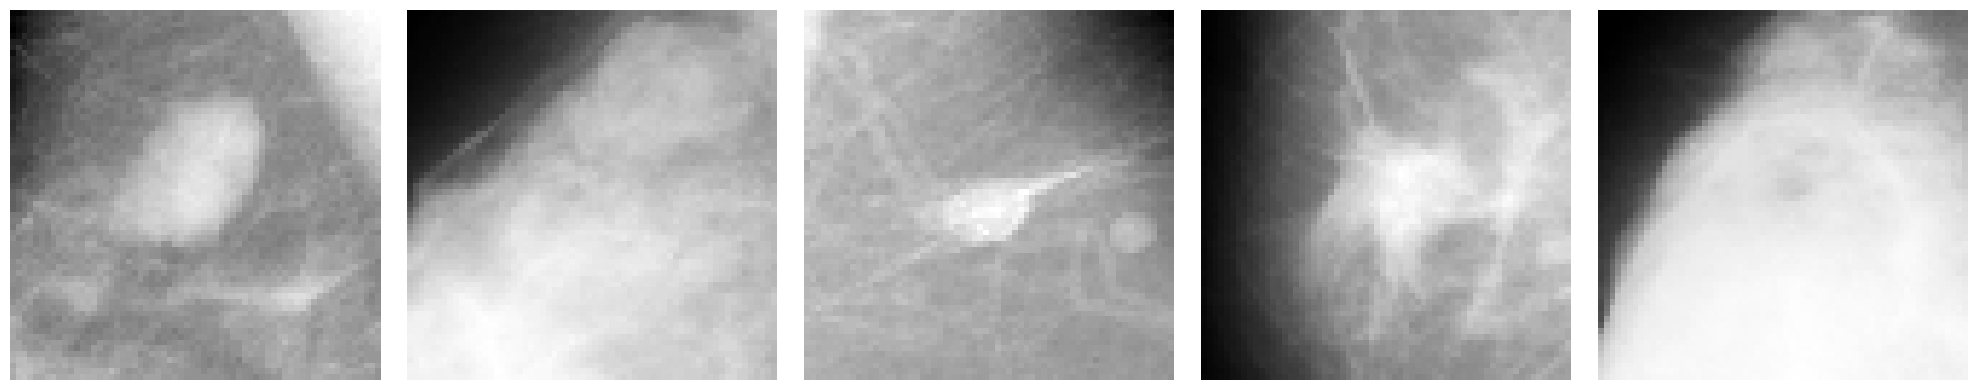

In [4]:
def visualize_random_images(images, num_images=5):
    selected_images = random.sample(list(images), num_images)
    
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Cargar las imágenes
(x_train, _), _ = load_mias_data()

visualize_random_images(x_train)

In [5]:
(x_train, _), (_, _) = load_mias_data()
x_train = x_train.astype('float32') / 255.0

In [6]:
def generator():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(128,)),
            layers.Dense(256, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(1024, activation="relu"),
            layers.Dense(64 * 64, activation="sigmoid"),
            layers.Reshape((64, 64)),
        ]
    )
    return model

In [7]:
def discriminator():
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(64, 64)),
            layers.Flatten(),
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    return model

In [8]:
generator = generator()
discriminator = discriminator()

In [9]:
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
z = layers.Input(shape=(128,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

In [11]:
combined = keras.Model(z, validity)
combined.compile(optimizer="adam", loss="binary_crossentropy")

In [12]:
def train(epochs, batch_size=128):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 128))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 128))
        g_loss = combined.train_on_batch(noise, valid)

        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")


In [13]:
train(epochs=100, batch_size=128)

4/4 [==============================] - 0s 6ms/step


0/100 [D loss: 7.828628778457642 | D accuracy: 0.0390625] [G loss: 0.0010742794256657362]
4/4 [==============================] - 0s 5ms/step
1/100 [D loss: 2.4406675596546847 | D accuracy: 0.5] [G loss: 0.2645881474018097]
4/4 [==============================] - 0s 6ms/step
2/100 [D loss: 0.5686975717544556 | D accuracy: 0.5] [G loss: 2.4393372535705566]
4/4 [==============================] - 0s 6ms/step
3/100 [D loss: 1.7588374018669128 | D accuracy: 0.5] [G loss: 1.3178281784057617]
4/4 [==============================] - 0s 5ms/step
4/100 [D loss: 1.9590263366699219 | D accuracy: 0.0] [G loss: 0.2570580244064331]
4/4 [==============================] - 0s 7ms/step
5/100 [D loss: 1.9667471647262573 | D accuracy: 0.0] [G loss: 0.09227699041366577]
4/4 [==============================] - 0s 5ms/step
6/100 [D loss: 1.9569936990737915 | D accuracy: 0.5] [G loss: 0.10299187898635864]
4/4 [==============================] - 0s 6ms/step
7/100 

1/1 [==============================] - 0s 96ms/step


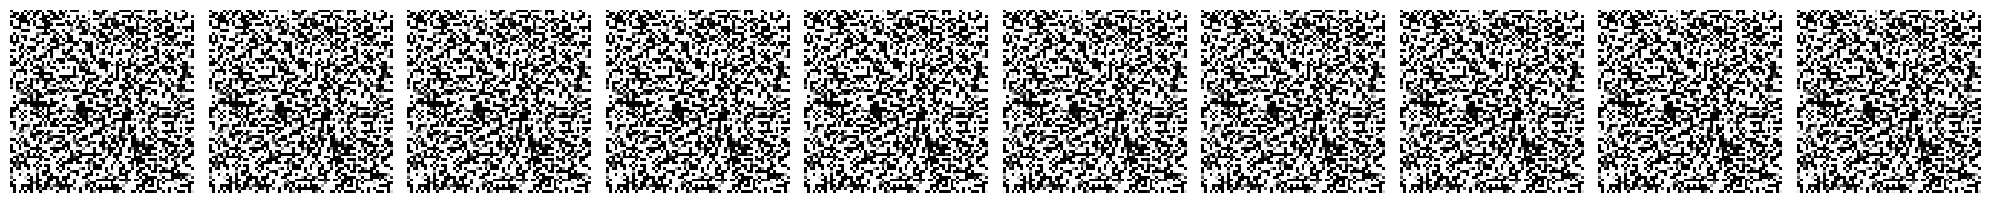

In [14]:
def generate_and_visualize_images(generator, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 128))
    generated_images = generator.predict(noise)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Genera y visualiza 10 imágenes después de entrenar la GAN
generate_and_visualize_images(generator, num_images=10)